In [2]:
#!/usr/bin/env python
"""
Demo for 1D Deblurring test problem on a small scale problem
--------------------------------------------------------------------------
Created in 2023 for TRIPs-Py library
"""
__authors__ = "Mirjeta Pasha and Silvia Gazzola"
__affiliations__ = 'MIT and Tufts University, and University of Bath'
__copyright__ = "Copyright 2023, TRIPs-Py library"
__license__ = "Apache"
__version__ = "1.0"
__email__ = "mpasha@mit.edu; mirjeta.pasha1@gmail.com; sg968@bath.ac.uk;"

In [4]:
import scipy.stats as sps
import scipy.io as spio
import matplotlib.pyplot as plt
import os
from venv import create
from trips.test_problems.Deblurring1D import *
from trips.utilities.operators import *
from trips.utilities.helpers import *
from trips.utilities.decompositions import gsvd
from trips.solvers.GKS import *
from trips.solvers.tSVD import *
from trips.solvers.tGSVD import *
from trips.solvers.Hybrid_GMRES import *
from trips.solvers.Hybrid_LSQR import *

#### In this notebook we illustrate how to use the Deblurring1D class.
Specifically, we will:
 - Define a Deblurring1D problem where the forward operator can be potentially formed explicitly as a matrix
 - Compute the naive solution
 - Show how to compute the (G)SVD and the truncated (G)SVD solution
 - Show how to compute the (standard and general form) Tikhonov solution
 - Show the usage of some iterative regularization methods, namely:
   - Hybrid GMRES
   - Hybrid LSQR
   - GKS


#### Define e Deblurring1D problem where the forward operator can be accessed explicitly as a matrix

We define an operator, choose an image of any given size and plot the true image and the blurred and noisy data as follows:

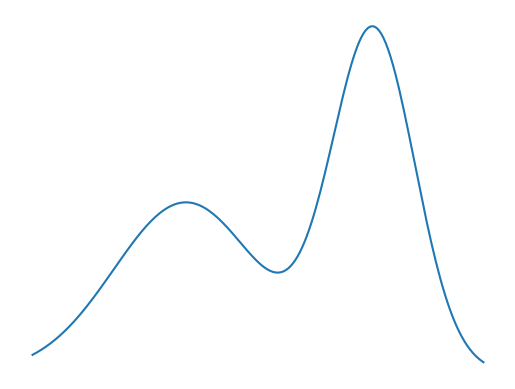

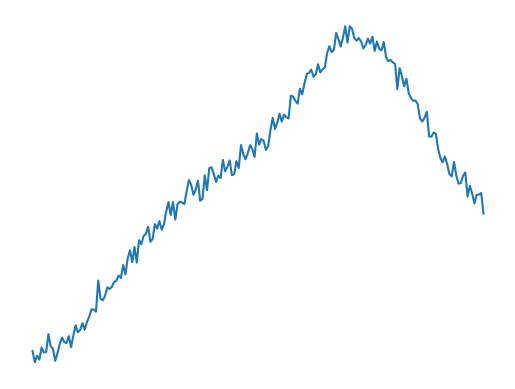

<Figure size 640x480 with 0 Axes>

In [5]:
Deblur1D = Deblurring1D(CommitCrime = True)
nx = 200
x_true = Deblur1D.gen_xtrue(nx, test = 'curve0')
# If you would like to create the operator only
A = Deblur1D.forward_Op_1D(parameter = 30, nx = nx) 
# The following creates the data b_true
b_true = Deblur1D.gen_data(x_true)
(d, delta) = Deblur1D.add_noise(b_true, 'Gaussian', noise_level = 0.02)
b_vec = d.reshape((-1,1))
# Display relevant quantities using the methods of the Deblurring1D class 
Deblur1D.plot_rec(x_true)
Deblur1D.plot_data(d)

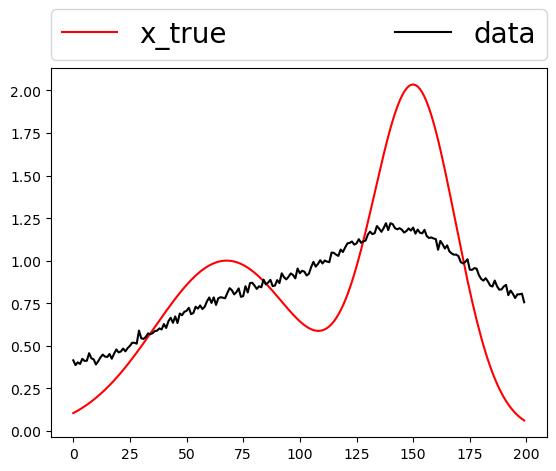

In [6]:
# Plotting ground truth and data in the same window
plt.plot(x_true, "r-", label='x_true')
plt.plot(b_vec, "k-", label='data')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0., fontsize=20)
plt.show()

#### Compute and display the naive solution, illustrating the ill-posedness of this inverse problem examples and the need for regularization

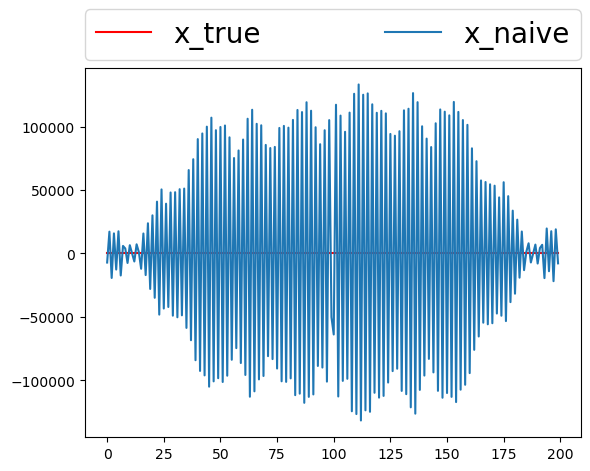

In [7]:
x_naive = np.linalg.solve(A.todense(), b_vec)
# showing the naive solution, along with the exact one
plt.plot(x_true, "r-", label='x_true')
plt.plot(x_naive, label='x_naive')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0., fontsize=20)
plt.show()

####  Compute the SVD of the operartor $A$ and plot the singlar values and the singular vectors
If the parameter is 'A' then we give the full operator to the function plot_singular_values_svd. The SVD is then computed and the singlar values are plotted. If the parameter is 'S' then we have precomputed the SVD from which we have S and the function plot_singular_values_svd will only plot the singular values. 
If the operator is sparse, we convert it to dense A.todense()
If the operator is in matrix form, but very large and sparse, the following commands can be used to compute the SVD
```python
import scipy
[U, S, V] = scipy.sparse.linalg.svds(A, 100)
```
where 100 is the number of singular values to be computed.

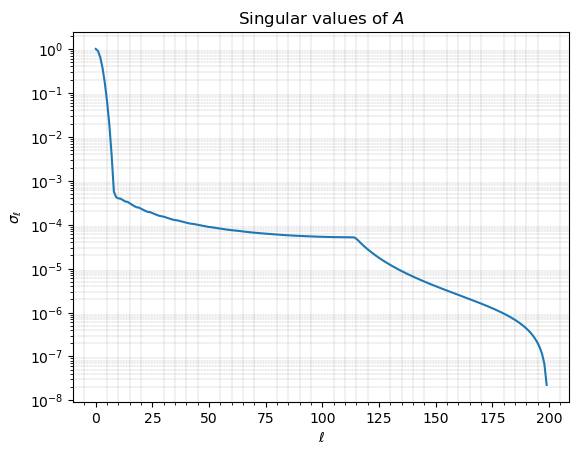

In [8]:
plot_singular_values_svd(Operator = A , parameter = 'A')

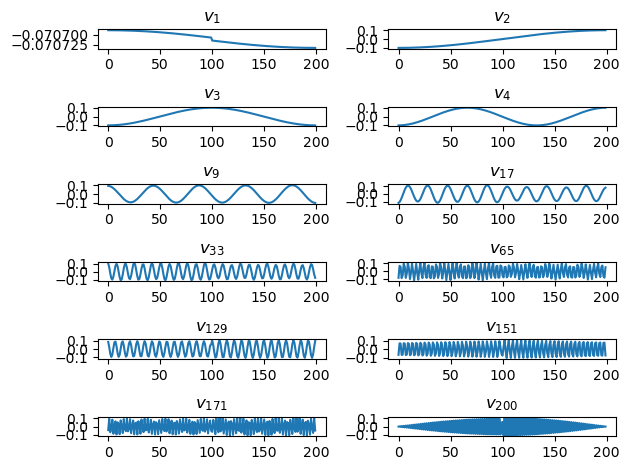

In [9]:
_, _, V = np.linalg.svd(A.todense())
idx = [0, 1, 2, 3, 8, 16, 32, 64, 128, 150, 170, 199]
fig, axes = plt.subplots(6, 2)
v_i = [V[k, :] for k in idx]
right_singular = np.array(v_i)
immax = np.max(right_singular)
immin = np.min(right_singular)
k = 0
for i in range(6):
    for j in range(2):
        sigvij = axes[i][j].plot(V[idx[k], :])
        axes[i][j].set_title(r'$v_{' + str(idx[k]+1) + r'}$')
        k += 1
    fig.tight_layout()
plt.show()

####  Compute the GSVD of $(A,L)$ where $L$ is a finite difference discretization of the first derivative operator

Note that our current GSVD implementation only supports $L$ square

In [10]:

L = gen_first_derivative_operator(nx)
# L = np.vstack((L.todense(), np.zeros((1,nx))))
L.shape
# A.shape

(199, 200)

In [9]:
from trips.solvers.Tikhonov import Tikhonov
# Define L
L = gen_first_derivative_operator(nx)
L = np.vstack((L.todense(), np.zeros((1,nx))))
# compute the GSVD of (A,L)
U, _, Z, C, S = gsvd(A.todense(),L) 
# basis vectors for the tGSVD solution
Y = np.linalg.inv(Z.T)

<ipython-input-12-8cd8251771e0>:1: RuntimeWarning: divide by zero encountered in divide
  plt.semilogy(np.diag(C)/np.diag(S))


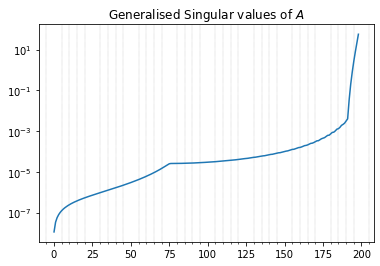

In [12]:
plt.semilogy(np.diag(C)/np.diag(S))
plt.title('Generalised Singular values of $A$')
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.2', color='black')

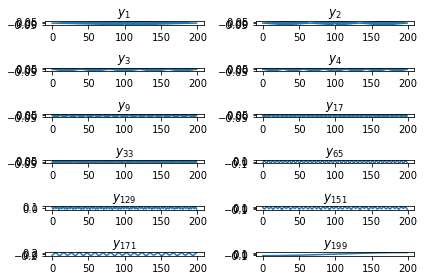

In [13]:
idx = [0, 1, 2, 3, 8, 16, 32, 64, 128, 150, 170, 198]
fig, axes = plt.subplots(6, 2)
y_i = [Y[:, k] for k in idx]
right_singular = np.array(y_i)
immax = np.max(right_singular)
immin = np.min(right_singular)
k = 0
for i in range(6):
    for j in range(2):
        sigyij = axes[i][j].plot(Y[:, idx[k]])
        axes[i][j].set_title(r'$y_{' + str(idx[k]+1) + r'}$')
        k += 1
    fig.tight_layout()
plt.show()

#### Compute the TSVD solution

The truncation parameter (regularization parameter) is selected according to the discrepancy principle, assigning in input also the magnitude of the noise in the data.

Truncation parameter is 6.


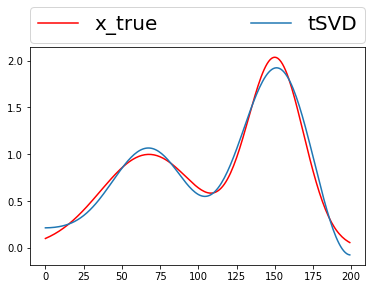

In [14]:
(x_tsvd, truncation_value) = tSVD_sol(A.todense(), b_vec, regparam = 'dp', delta = delta)
print("Truncation parameter is %s." % truncation_value)
# plot of the solution
plt.plot(x_true, "-r", label='x_true')
plt.plot(x_tsvd, label='tSVD')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0., fontsize=20)
plt.show()

#### Compute the TGSVD solution

The truncation parameter (regularization parameter) is selected according to the discrepancy principle, assigning in input also the magnitude of the noise in the data.

Truncation parameter is 4.


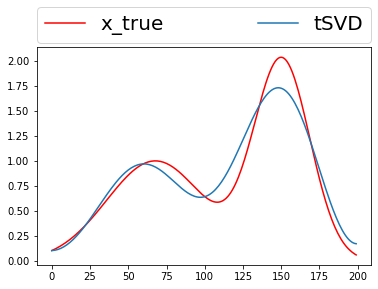

In [15]:
# Define the regularization operator (must be square)
L = gen_first_derivative_operator(nx)
L = np.vstack((L.todense(), np.zeros((1,nx))))
(x_tgsvd, truncation_value) = tGSVD_sol(A.todense(), L, b_vec, regparam = 'dp', delta = delta)
print("Truncation parameter is %s." % truncation_value)
# plot of the solution
plt.plot(x_true, "-r", label='x_true')
plt.plot(x_tgsvd, label='tSVD')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0., fontsize=20)
plt.show()

#### Compute the Tikhonov solution

Both Tikhonov in standard form (i.e., where the regularization matrix $L$ is the identity) and in general form (where $L$ is a finite difference discretization of the first derivative operator) are considered.

In [16]:
from trips.solvers.Tikhonov import Tikhonov
# Standard form Tikhonov
L = np.eye(int(A.shape[1]))
x_Tikh, lambda_Tikh = Tikhonov(A, b_vec, L, x_true, regparam = 'dp', delta = delta)
# General form Tikhonov
L = gen_first_derivative_operator(nx)
x_TikhL, lambda_TikhL = Tikhonov(A, b_vec, L.todense(), x_true, regparam = 'dp', delta = delta)

Plotting the Tikhonov solutions -- we can see that the one associated to general form Tikhonov regularization is smoother.

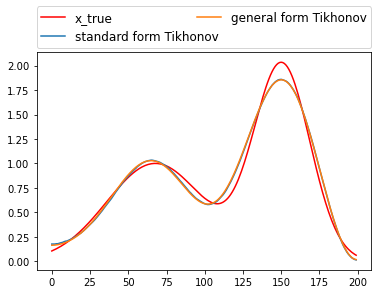

In [17]:
plt.plot(x_true, "-r", label='x_true')
plt.plot(x_Tikh, label='standard form Tikhonov')
plt.plot(x_TikhL, label='general form Tikhonov')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0., fontsize=12)
plt.show()

#### Applying iterative regularization: Hybrid GMRES and Hybrid LSQR

In [18]:
(x_hybrid_gmres, info_hybrid_gmres) = Hybrid_GMRES(A, b_vec, n_iter = 100, regparam = 'dp', x_true = x_true, delta = delta)
(x_hybrid_lsqr, info_hybrid_lsqr) = Hybrid_LSQR(A, b_vec, n_iter = 100, regparam = 'dp', x_true = x_true, delta = delta)

running Arnoldi algorithm...: 100%|██████████| 100/100 [00:00<00:00, 260.59it/s]
running Golub-Kahan bidiagonalization algorithm...: 100%|██████████| 100/100 [00:00<00:00, 354.91it/s]


#### Applying iterative regularization: the GKS method

Works with $L$, a finite difference discretization of the first derivative operator

In [19]:
# Define a derivative operator as a regularization operator
L = first_derivative_operator(nx)
# Use GKS to compute an approximate solution
(x_gks, info_gks) = GKS(A, b_vec, L, projection_dim=1, n_iter = 100, regparam = 'dp', delta = delta,
                        x_true = x_true.reshape(-1,1))

running GKS...: 100%|██████████| 100/100 [00:00<00:00, 174.90it/s]


Plotting relevant quantities to compare the iterative solvers:
- Relative error

Text(0, 0.5, '$\\|x_{true} - x_d\\|_2/\\|x_{true}\\|_2$')

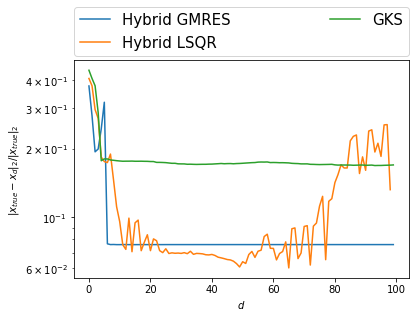

In [20]:
plt.semilogy(info_hybrid_gmres['relError'], label='Hybrid GMRES')
plt.semilogy(info_hybrid_lsqr['relError'], label='Hybrid LSQR')
plt.semilogy(info_gks['relError'], label='GKS')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0., fontsize=15)
plt.xlabel('$d$')
plt.ylabel('$\|x_{true} - x_d\|_2/\|x_{true}\|_2$')


- Regularization parameter

Text(0, 0.5, '$\\lambda_d$')

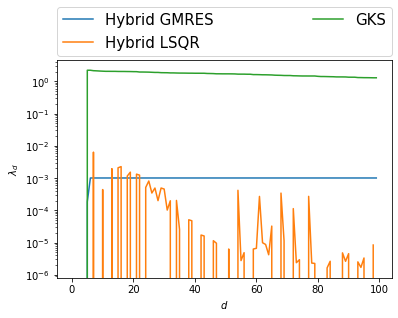

In [21]:
plt.semilogy(info_hybrid_gmres['regParam_history'], label='Hybrid GMRES')
plt.semilogy(info_hybrid_lsqr['regParam_history'], label='Hybrid LSQR')
plt.semilogy(info_gks['regParam_history'], label='GKS')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0., fontsize=15)
plt.xlabel('$d$')
plt.ylabel('$\lambda_d$')

- Solutions

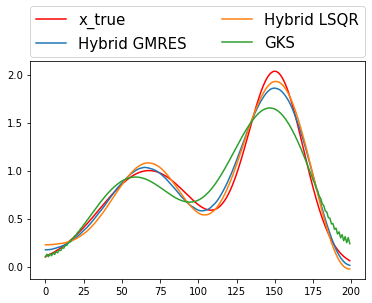

In [22]:
plt.plot(x_true, "-r", label = 'x_true')
plt.plot(x_hybrid_gmres, label = 'Hybrid GMRES')
plt.plot(info_hybrid_lsqr['xHistory'][20], label = 'Hybrid LSQR')
plt.plot(info_gks['xHistory'][20], label = 'GKS')
# plot_mmgks = plt.plot(info_mmgks['xHistory'][0], label = 'x_mmgks[20]')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0., fontsize=15)
plt.show()

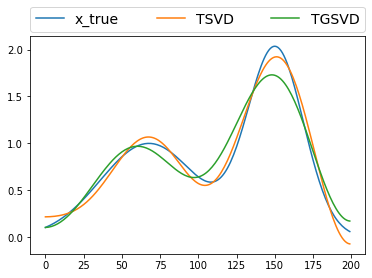

In [23]:
plt.plot(x_true, label='x_true')
plt.plot(x_tsvd, label='TSVD')
plt.plot(x_tgsvd, label='TGSVD')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0., fontsize=14)
plt.show()

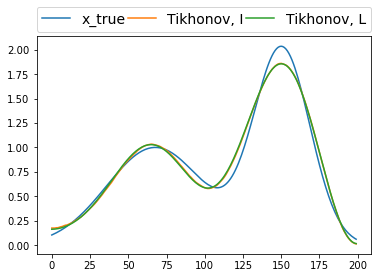

In [24]:
plt.plot(x_true, label='x_true')
plt.plot(x_Tikh, label='Tikhonov, I')
plt.plot(x_TikhL, label='Tikhonov, L')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0., fontsize=14)
plt.show()

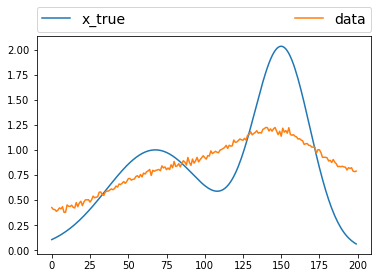

In [25]:
plt.plot(x_true, label='x_true')
plt.plot(b_vec, label='data')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0., fontsize=14)
plt.show()

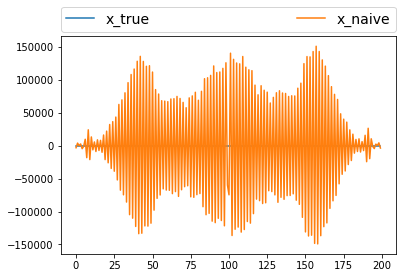

In [26]:
plt.plot(x_true, label='x_true')
plt.plot(x_naive, label='x_naive')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0., fontsize=14)
plt.show()